In [23]:
import typing as tp

import numpy as np

In [35]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None) -> None:
        self.feature: tp.Optional[int] = feature
        self.threshold: tp.Optional[float] = threshold
        self.left: tp.Optional[Node] = left
        self.right: tp.Optional[Node] = right
        self.value: tp.Optional[np.signedinteger] = value

    def is_leaf(self) -> bool:
        return self.value is not None


class CustomDecisionTree:
    def __init__(self, max_depth: tp.Optional[int] = None, min_samples_split: int = 2,
                 min_samples_leaf: int = 1) -> None:
        self.max_depth: tp.Optional[int] = max_depth
        self.min_samples_to_split: int = min_samples_split
        self.min_samples_leaf: int = min_samples_leaf
        self.tree: tp.Optional[Node] = None
        self.cur_depth: tp.Optional[int] = 0

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X: np.ndarray, y: np.ndarray, depth: int = 0) -> Node:
        n_samples, n_features = X.shape
        self.n_classes = len(np.unique(y))
        if self.max_depth and depth >= self.max_depth \
                or self.n_classes == 1 \
                or n_samples < self.min_samples_to_split:
            leaf_value: np.signedinteger = self._most_common_label(y)
            return Node(value=leaf_value)

        rand_features = np.random.choice(n_features, n_features, replace=False)
        best_feature, best_threshold = self._best_criteria(X, y, rand_features)
        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)

        if len(left_idxs) < self.min_samples_leaf or len(right_idxs) < self.min_samples_leaf:
            leaf_value: np.signedinteger = self._most_common_label(y)
            return Node(value=leaf_value)
        self.cur_depth += 1
        left = self._build_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._build_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)

    def _best_criteria(self, X: np.ndarray, y: np.ndarray, features: np.ndarray) -> tuple[int, float]:
        best_gain = -1
        best_feature, best_threshold = None, None
        for feature in features:
            X_column_by_feature = X[:, feature]
            thresholds = np.unique(X_column_by_feature)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column_by_feature=X_column_by_feature, split_thresh=threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold

    def _information_gain(self, y, X_column_by_feature: np.ndarray, split_thresh: float) -> float:
        parent_entropy = self._calc_entropy(y)
        left_idxs, right_idxs = self._split(X_column_by_feature, split_thresh)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n_total, n_left, n_right = len(y), len(left_idxs), len(right_idxs)
        entropy_left, entropy_right = self._calc_entropy(y[left_idxs]), self._calc_entropy(y[right_idxs])
        k_left, k_right = n_left / n_total, n_right / n_total
        child_entropy = k_left * entropy_left + k_right * entropy_right
        ig = parent_entropy - child_entropy
        return ig

    @staticmethod
    def _split(X_column_by_feature: np.ndarray, split_thresh: float) -> tuple[np.ndarray, np.ndarray]:
        left_idxs = np.argwhere(X_column_by_feature <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column_by_feature > split_thresh).flatten()
        return left_idxs, right_idxs

    @staticmethod
    def _calc_entropy(y: np.ndarray) -> float:
        p_lst = np.bincount(y) / len(y)
        return -np.sum([p * np.log2(p) for p in p_lst if p > 0])

    @staticmethod
    def _most_common_label(y: np.ndarray) -> np.signedinteger:
        return np.bincount(y).argmax()

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _traverse_tree(self, x, node) -> np.signedinteger:
        if node.is_leaf():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


In [36]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer


In [37]:
def _get_split_data() -> tp.Any:
    data = load_breast_cancer()
    X, y = data.data, data.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_test, X_train, y_test, y_train

In [38]:
def pretty_print_best_params(best_params: dict, best_score: float) -> None:
    print(f"Best Score: {best_score:.4f}")
    print("Best Parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")


def print_accuracy(y_pred, y_test) -> None:
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy}")

In [39]:
def test_decision_tree() -> None:
    X_test, X_train, y_test, y_train = _get_split_data()
    dt = CustomDecisionTree()
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    print_accuracy(y_pred, y_test)

In [40]:
test_decision_tree()

Test Accuracy: 0.9473684210526315


In [41]:
import pandas as pd

In [42]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [43]:
data = load_breast_cancer()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
import matplotlib.pyplot as plt

In [49]:
def plot_tree_depth_by_params(
        min_samples_split_lst,
        min_samples_leaf_lst,
        X_train,
        y_train
):
    depth_lst = []
    labels = []

    for min_samples_split in min_samples_split_lst:
        for min_samples_leaf in min_samples_leaf_lst:
            dt = CustomDecisionTree(min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
            dt.fit(X_train, y_train)
            max_depth = dt.cur_depth
            depth_lst.append(max_depth)
            labels.append(
                f"split:{min_samples_split};leaf:{min_samples_leaf}"
            )
    plt.figure(figsize=(10, 6))
    plt.plot(depth_lst)
    plt.xticks(range(len(depth_lst)), labels, rotation=45, ha='right')
    plt.xlabel("Hyperparameters")
    plt.ylabel("Tree depth")
    plt.title("Tree depth by hyperparameters")
    plt.show()

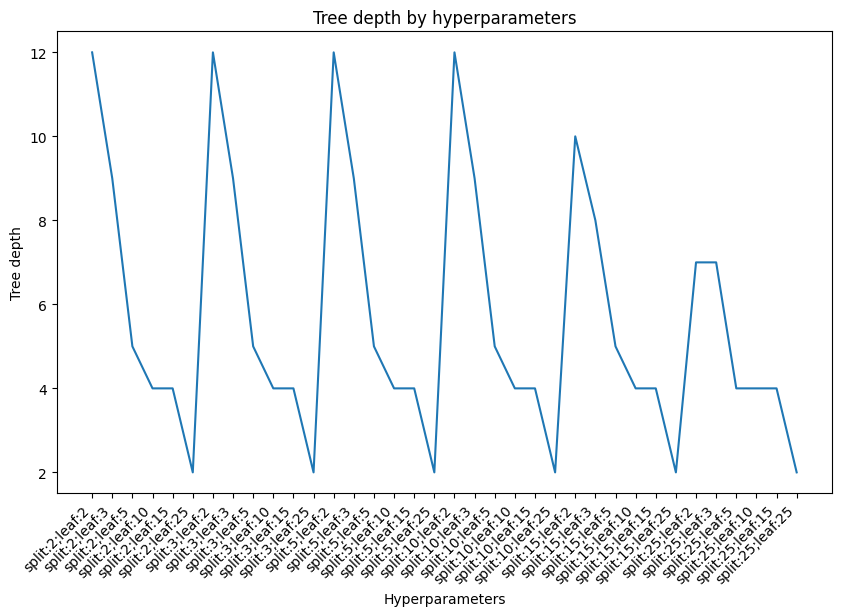

In [51]:
# min_samples_split_lst = [i for i in range(2, 31)]
min_samples_split_lst = [2, 3, 5, 10, 15, 25]
# min_samples_leaf_lst = [i for i in range(1, 31)]
min_samples_leaf_lst = [2, 3, 5, 10, 15, 25]

plot_tree_depth_by_params(
    min_samples_split_lst=min_samples_split_lst,
    min_samples_leaf_lst=min_samples_leaf_lst,
    X_train=X_train,
    y_train=y_train
)


In [ ]:
import optuna
import numpy as np


In [32]:
def func(trial, X_train: np.ndarray, X_val: np.ndarray, y_train: np.ndarray, y_val: np.ndarray) -> float:
    max_depth = trial.suggest_int('max_depth', 2, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 30)
    dt = CustomDecisionTree(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
    )
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

In [33]:
def get_best_hyperparameters(
        X_train: np.ndarray, X_val: np.ndarray, y_train: np.ndarray, y_val: np.ndarray
) -> tuple[dict, float]:
    study = optuna.create_study(direction='maximize')
    study.optimize(
        func=lambda trial: func(trial, X_train, X_val, y_train, y_val),
        n_trials=100,
        show_progress_bar=True
    )
    best_params = study.best_params
    best_value = study.best_value
    return best_params, best_value


In [34]:
def get_split_data():
    data = load_breast_cancer()
    X, y = data.data, data.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    return X_test, X_train, X_val, y_test, y_train, y_val

In [35]:
X_test, X_train, X_val, y_test, y_train, y_val = get_split_data()
best_params, best_score = get_best_hyperparameters(X_train, X_val, y_train, y_val)
print("~" * 40)
pretty_print_best_params(best_params, best_score)

[I 2024-09-11 16:21:32,420] A new study created in memory with name: no-name-41fdc80b-782d-41c6-bc59-b71f1c37ae74


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-09-11 16:21:33,046] Trial 0 finished with value: 0.9120879120879121 and parameters: {'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.9120879120879121.
[I 2024-09-11 16:21:33,639] Trial 1 finished with value: 0.9230769230769231 and parameters: {'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.9230769230769231.
[I 2024-09-11 16:21:34,208] Trial 2 finished with value: 0.9010989010989011 and parameters: {'max_depth': 21, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.9230769230769231.
[I 2024-09-11 16:21:34,780] Trial 3 finished with value: 0.9230769230769231 and parameters: {'max_depth': 23, 'min_samples_split': 21, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.9230769230769231.
[I 2024-09-11 16:21:35,347] Trial 4 finished with value: 0.9010989010989011 and parameters: {'max_depth': 30, 'min_samples_split': 20, 'min_samples_leaf': 18}. Best is trial

In [36]:
import matplotlib.pyplot as plt

In [37]:
def plot_accuracy_vs_depth(X_test, X_train, y_test, y_train,
                           min_samples_split, min_samples_leaf, depth_lst):
    train_accuracies = []
    test_accuracies = []

    for depth in depth_lst:
        dt = CustomDecisionTree(
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_depth=depth,
        )
        dt.fit(X_train, y_train)

        y_train_pred = dt.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_test_pred = dt.predict(X_test)
        test_accuracies.append(accuracy_score(y_test, y_test_pred))

    plt.plot(depth_lst, train_accuracies, label='Train Accuracy')
    plt.plot(depth_lst, test_accuracies, label='Test Accuracy')
    plt.xlabel('Depth')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Depth')
    plt.legend()
    plt.show()

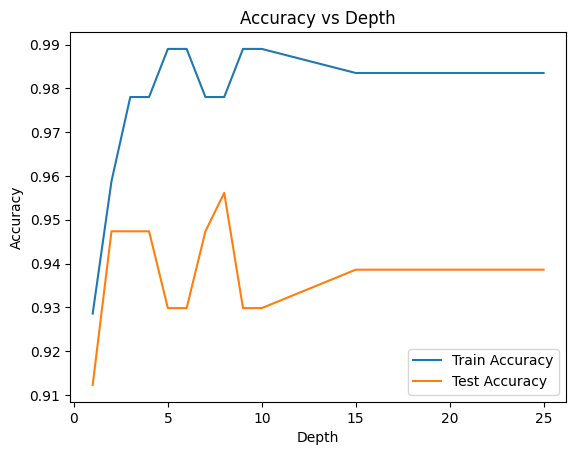

In [38]:
depth_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 25]
plot_accuracy_vs_depth(
    depth_lst=depth_lst,
    X_test=X_test,
    X_train=X_train,
    y_test=y_test,
    y_train=y_train,
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf']
)